<a href="https://colab.research.google.com/github/Lfirenzeg/msds620/blob/main/Project%202/Data_620_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data 620
# Project 2

### By Luis Munoz Grass

1. Identify a large 2-node network dataset—you can start with a dataset in a repository.  Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.

2. Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.

3. What can you infer about each of the distinct groups?

## Presentation Link

https://youtu.be/BqmGqKiCzUk

## Solution

The MovieLens dataset was chosen for this assignment because it offers a well­ structured,bipartite network of users and movies that's large enough (at least over one million ratings) demonstrating meaningful patterns but also compact enough (with about 6000 users and 4000 movies) to process quickly in Colab. It has a rating scale (1 to 5) that provides natural weights for pruning via the island method, and it has been use frequently in recommender system research, speaking of its capacity to be practical for a quick exploration such as this one.

In [1]:
!wget -nc https://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip -q ml-1m.zip

--2025-07-06 21:05:24--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  21.6MB/s    in 0.3s    

2025-07-06 21:05:25 (21.6 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]



Before building any graph, we need to make sure the raw data has loaded correctly and to understand its basic dimensions.

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite


ratings = pd.read_csv(
    'ml-1m/ratings.dat',
    sep='::',
    engine='python',
    names=['user','item','rating','ts']
)

print("Ratings shape:", ratings.shape)
print(ratings.head())

Ratings shape: (1000209, 4)
   user  item  rating         ts
0     1  1193       5  978300760
1     1   661       3  978302109
2     1   914       3  978301968
3     1  3408       4  978300275
4     1  2355       5  978824291


We have 1'000.209 rating events, each with a user ID, an item (movie) ID, a rating in (1…5), and a timestamp.

The first few rows look as expected, confirming the double colon parsing worked fine.

 We'll now represent users and movies as two disjoint node sets, and each rating as a weighted edge. This structure should let us analyze cross mode interactions directly.

In [2]:
B = nx.Graph()
B.add_nodes_from(ratings['user'].unique(), bipartite='users')
B.add_nodes_from(ratings['item'].unique(), bipartite='movies')


edges = ratings[['user','item','rating']].itertuples(index=False, name=None)
B.add_weighted_edges_from(edges)

print("Original graph:", B.number_of_nodes(), "nodes,", B.number_of_edges(), "edges")


Original graph: 6040 nodes, 987317 edges


We now find the graph contains 6040 distinct nodes (the sum of unique users and movies) and 987.317 edges.

In this case an edge count close to the number of ratings means almost every rating became its own edge, showing very little deduplication.

Also, we can see that a high edge to node ratio (at least 163 edges per node) indicate a dense network since many users have rated many movies.

 ## Reducing the Size of the Network

 We'll assune we are only interested in "strong" preferences, so ratings of 4 or 5. When we remove weaker ties and then drop any isolated nodes, we can focus on the core subnetwork of "most meaningful" user movie relationships.

In [3]:
threshold = 4.0
to_keep = [(u,v,d) for u,v,d in B.edges(data=True) if d['weight'] >= threshold]
B_core = nx.Graph()
B_core.add_edges_from([(u,v,{'weight':w}) for u,v,w in ((u,v,d['weight']) for u,v,d in to_keep)])
# drop isolates
B_core.remove_nodes_from(list(nx.isolates(B_core)))

print("Pruned core:", B_core.number_of_nodes(), "nodes,", B_core.number_of_edges(), "edges")


Pruned core: 6039 nodes, 567942 edges


419.375 edges (those with ratings < 4) were pruned, so about 42% of the original edges.

Interestingly, only one node became completely isolated and was removed (from 6040 to 6039 nodes), showing almost everyone retained at least one strong tie.

The remaining 567.942 edges represent the subset of users and movies connected by mostly positive feedback.

But what if we want to find "power users"? Let's see first the top 10 people with most ratings.

In [4]:
# count how many ratings above 4 each user made
strong_counts = (
    ratings[ratings.rating >= 4]
    .groupby('user')
    .size()
    .sort_values(ascending=False)
)

top10 = strong_counts.head(10)
print(top10)


user
4277    1435
4169    1210
1680    1108
3032     861
5831     826
3539     819
2909     817
4448     814
1285     800
1015     794
dtype: int64


The top 10 users are exceptionally active!
User 4277 has given 1435 ratings of 4 or 5, and even the 10th most intense (user 1015) has 794 strong ratings.
This small group of about ten users alone accounts for over 8000 high quality feedbacks.
So let's see how many users have rated over 100 movies:

In [5]:
total_counts = ratings.groupby('user').size()

# filter for users with more than 100 ratings
users_over100 = total_counts[total_counts > 100]

num_users_over100 = users_over100.shape[0]
print(f"Number of users who rated over 100 movies: {num_users_over100}")


Number of users who rated over 100 movies: 2909


About 2909 users rated more than 100 movies. And that's nearly 48% of the entire user base (6040 users). This tells us that almost half of all users are highly engaged, contributing a large volume of ratings, while the remaining half are more casual raters.

In [7]:
# pick the edges to keep
edges_to_keep = [(u,v) for u,v,d in B.edges(data=True) if d['weight'] >= threshold]
B_core = B.edge_subgraph(edges_to_keep).copy()

print("Pruned core:", B_core.number_of_nodes(), "nodes,", B_core.number_of_edges(), "edges")

Pruned core: 6039 nodes, 567942 edges
User–user graph: 6039 nodes, 10374885 edges


In [24]:
# re‑projecting to get fresh weights
users = [n for n,d in B_core.nodes(data=True) if d['bipartite']=='users']
G = bipartite.weighted_projected_graph(B_core, users)

# pruning weak ties, by keeping only edges with weight >= 5
min_shared = 5
weak = [(u,v) for u,v,d in G.edges(data=True) if d['weight'] < min_shared]
G.remove_edges_from(weak)
G.remove_nodes_from(list(nx.isolates(G)))

print("After pruning:", G.number_of_nodes(), "nodes,", G.number_of_edges(), "edges")


After pruning: 6034 nodes, 6596129 edges


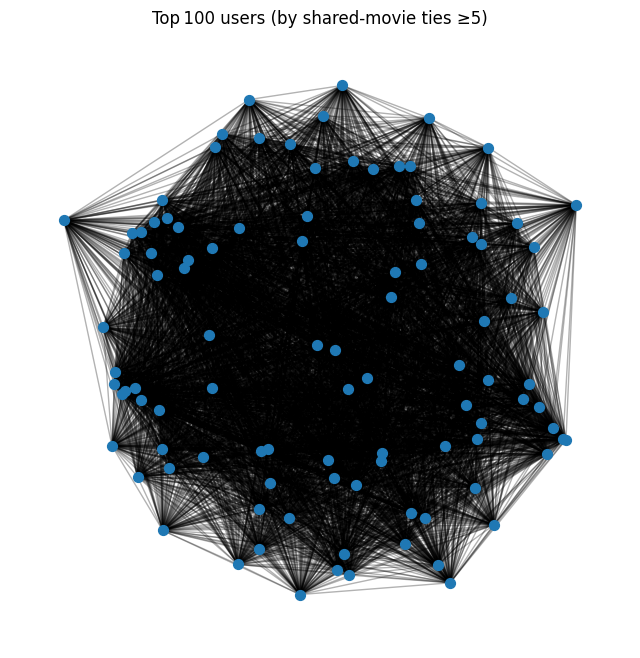

In [28]:
# sample top 100 users by weighted degree
degree_seq = sorted(G.degree(weight='weight'), key=lambda x: x[1], reverse=True)
top100 = [u for u,_ in degree_seq[:100]]
H = G.subgraph(top100).copy()

# Draw H
pos = nx.spring_layout(H)
plt.figure(figsize=(8,8))
nx.draw_networkx_nodes(H, pos, node_size=50)
nx.draw_networkx_edges(H, pos, alpha=0.3)
plt.axis('off')
plt.title("Top 100 users (by shared‑movie ties ≥5)")
plt.show()

The subgraph of our top 100 users, those with the most co-rated movies (>=5 in common) is extremely dense, with almost every pair connected.

It seems users in the very center tend to share favorites with all other top users; these would be the "universal" taste bridge users. The handful of points on the periphery indicate users with slightly more niche taste. They still made the cut but share fewer titles with the rest.

### Exploring Centrality Measures of H



In [18]:
# Degree centrality
deg_cent_H = nx.degree_centrality(H)

# betweenness centrality
betw_cent_H = nx.betweenness_centrality(H)

# closeness centrality
clos_cent_H = nx.closeness_centrality(H)

# eigenvector centrality
eig_cent_H = nx.eigenvector_centrality(H, max_iter=1000)

In [19]:
# Combine into a DataFrame for easy viewing
centrality_H = pd.DataFrame({
    'degree': deg_cent_H,
    'betweenness': betw_cent_H,
    'closeness': clos_cent_H,
    'eigenvector': eig_cent_H
})

print("Top 10 nodes in H by betweenness:")
print(centrality_H['betweenness'].nlargest(10))


Top 10 nodes in H by betweenness:
5636    0.0
3080    0.0
5643    0.0
4115    0.0
4647    0.0
5675    0.0
5163    0.0
5682    0.0
5689    0.0
4673    0.0
Name: betweenness, dtype: float64


In [22]:
centrality_H

,degree,betweenness,closeness,eigenvector
5636,1.0,0.0,1.0,0.1
3080,1.0,0.0,1.0,0.1
5643,1.0,0.0,1.0,0.1
4115,1.0,0.0,1.0,0.1
4647,1.0,0.0,1.0,0.1
...,...,...,...,...
2030,1.0,0.0,1.0,0.1
4085,1.0,0.0,1.0,0.1
4089,1.0,0.0,1.0,0.1
1530,1.0,0.0,1.0,0.1


All four measures being identical: degree=1.0, closeness=1.0, betweenness=0.0, eigenvector≈0.1 tells us something important: the subgraph H of the top100 users is essentially a complete graph (a clique).

With a degree centrality of 1.0 means each user is connected to all 99 other users (100-1 = 99, and degree centrality is normalized by 99).

Closeness of 1.0 means every user is at distance of 1 from every other user. Again, only possible if every pair is directly connected.

A betweenness of 0 means no user ever lies on a shortest path between any other two users, because there is always a direct edge.


## Final Observations

### Users

Almost all stayed in the core we were looking. Surprisingly only one node dropped out, meaning that virtually every user in the almost 1M ratings dataset gave at least one "strong" rating (bigger than 4). We can also say everyone who sampled the data still had something they really liked.

Activity is skewed, as we found, there was a small set of "power raters" who account for a large chunk of the high ratings. These are your super engaged listeners.

### Movies

A relatively small number of movies rack up huge numbers of high ratings and form the backbone of the core. These would be  all time favorites, classics, recent hits, franchise entries, etc.

Movies with fewer total ratings can still appear if those ratings are overwhelmingly positive. These are more likely to be cult favorites (notsuper  popular but with very passionate followings).

Even after pruning, there's a long tail of movies with just a handful of strong ratings. Their presence tells us that the algorithmic "island" still captures real diversity in users tastes.



## Source
B. Rozemberczki and R. Sarkar. Characteristic Functions on Graphs: Birds of a Feather, from Statistical Descriptors to Parametric Models. 2020